In [4]:
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Question 1
Train and validate your own n-layer Neural Network on the Apparel dataset
to predict the class label of a given apparel. You are free to choose the hyper-parameters,
training strategy to handle large number of training data (Hint: Batch Size) architecture number of hidden layers, number of nodes in each hidden layer etc.

In [5]:
train_df = pd.read_csv('Apparel/apparel-trainval.csv')

In [3]:
#train_df.iloc[:,1:] = (train_df.iloc[:,1:] - train_df.iloc[:,1:].mean())/train_df.iloc[:,1:].std()

In [118]:
class NeuralNetwork:
    def __init__(self, layer_dims, learning_rate = 0.1, itr = 100, batch_size=512, activation = 'relu', lamda=0.1):
        self.number_of_layers = len(layer_dims)
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.itr = itr
        self.batch_size = batch_size
        self.parameters = {}
        self.activation = activation
        self.lamda = lamda
        #self.grads = {}
    def initialize_parameters(self):
        for l in range(1, self.number_of_layers):
            self.parameters['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1])*np.sqrt(1/self.layer_dims[l-1])
            self.parameters['b' + str(l)] = np.zeros((self.layer_dims[l],1))
    def sigmoid(self, x):
        return np.exp(x)/(1+np.exp(x)), x
    def sigmoid_backward(self, dA, Z):
        q,_ = self.sigmoid(Z)
        #print(q.shape)
        return dA*(q*(1-q))
    def relu(self, x):
        return np.maximum(x, 0), x
    def relu_backward(self, dA, Z):
        q = Z>=0.0
        #print(np.unique(q))
        return dA*q.astype(np.int)
    def softmax(self, x):
        x = x - p.max(x)
        num = np.exp(x)
        den = np.sum(num)
        return np.divide(num, den), x
    def softmax_backward(self, dA, Z):
        q,_ = self.softmax(Z)
        #print(q)
        return dA*(q*(1-q))
    def tanh(self, x):
        return np.tanh(x), x
    def tanh_backward(self, dA, x):
        q,_ = self.tanh(x)
        q = 1- np.square(q)
        #q = np.squeeze(q, axis = (1,))
        #print(q)
        #print(q.shape, dA.shape)
        return dA*q
    def linear_forward(self, A, W, b):
        #print(b.shape, W.shape, A.shape)
        Z = np.dot(W,A) + b
        cache = (A, W, b)
        return Z, cache
    def linear_activation_forward(self, A_prev, W, b, activation):
        if activation == 'sigmoid':
            Z, linear_cache = self.linear_forward(A_prev, W, b)
            A, activation_cache = self.sigmoid(Z)
        elif activation == 'relu':
            Z, linear_cache = self.linear_forward(A_prev, W, b)
            A, activation_cache = self.relu(Z)
        elif activation == 'tanh':
            Z, linear_cache = self.linear_forward(A_prev, W, b)
            A, activation_cache = self.tanh(Z)
        elif activation == 'softmax':
            Z, linear_cache = self.linear_forward(A_prev, W, b)
            A, activation_cache = self.softmax(Z)
        cache = (linear_cache, activation_cache)
        return A, cache
    def forward_propagation(self, X):
        caches = []
        A = X
        L = len(self.parameters)//2
        for l in range(1, L):
            A_prev = A
            A, cache = self.linear_activation_forward(A_prev, self.parameters['W'+str(l)], self.parameters['b'+str(l)], self.activation)
            caches.append(cache)
            
        AL, cache = self.linear_activation_forward(A, self.parameters['W'+str(L)], self.parameters['b'+str(L)], activation='sigmoid')
        caches.append(cache)
        return AL, caches
    def linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = np.dot(dZ, A_prev.T)/m
        db = np.squeeze(np.sum(dZ, axis = 1, keepdims = True))/m
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db
    def linear_activation_backward(self, dA, cache, activation):
        linear_cache, activation_cache = cache
        
        if activation == 'sigmoid':
            dZ = self.sigmoid_backward(dA, activation_cache)
        elif activation == 'relu':
            dZ = self.relu_backward(dA, activation_cache)
        elif activation == 'tanh':
            dZ = self.tanh_backward(dA, activation_cache)
        dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
            
        return dA_prev, dW, db
    def backward_propagation(self, AL, Y, caches):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -np.nan_to_num((np.nan_to_num(np.divide(Y, AL))) - np.nan_to_num(np.divide(1-Y, 1-AL)))
        #print(dAL)
        current_cache = caches[-1]
        grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = self.linear_backward(
                                                                                self.sigmoid_backward(dAL,current_cache[1]), 
                                                                                current_cache[0])
        grads["db" + str(L)] = grads["db" + str(L)] .reshape(self.parameters["b"+str(L)].shape)
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dAL = grads["dA"+str(l+2)]
            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(dAL, current_cache, self.activation)
            grads["dA" + str(l + 1)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp.reshape(self.parameters["b"+str(l+1)].shape)

        return grads
        
    def update_parameter(self, grads, m):
        L = len(self.parameters)//2
        for l in range(L):
            self.parameters["W" + str(l + 1)] = (1-(self.learning_rate*self.lamda)/m)*self.parameters["W" + str(l + 1)] - self.learning_rate * grads["dW" + str(l + 1)]
            #print(grads['dW'+str(l+1)].shape)
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - self.learning_rate * grads["db" + str(l + 1)]

    def compute_cost(self, AL, Y,m, activation='sigmoid'):
        #m = Y.shape[1]
        if activation == 'sigmoid' or activation == 'tanh':
            cost = -(1/m) *(np.sum(np.nan_to_num(np.multiply(Y, np.nan_to_num(np.log(AL))) + np.multiply(1 - Y, np.nan_to_num(np.log(1 - AL))))))
        elif activation == 'softmax':
            cost = -(1/m)* np.sum(np.multiply(Y, np.nan_to_num(np.log(AL))))
            #print(cost)
        cost = np.squeeze(cost)
        return cost
    def predict(self, X):
        pred_res, _ = self.forward_propagation(X)
        return pred_res
    def SGD(self, training_data, print_cost = False):
        costs = []
        self.initialize_parameters()
        
        for i in range(1, self.itr+1):
            #print(i)
            random.shuffle(list(training_data))
            m = len(training_data)
            mini_batches = [training_data[k:k+self.batch_size] for k in range(0, m, self.batch_size)]
            cost = 0
            for mini_batch in mini_batches:
                X = []
                Y = []
                for x,y in mini_batch:
                    X.append(x)
                    Y.append(y)
                    #print(X.shape)
                    #print(i)
                X = np.asarray(X)
                Y = np.asarray(Y)
                #print(X.shape)
                #print(Y.shape)
                AL, caches = self.forward_propagation(X.T)
                    #print(AL)
                    #print(Y)
                    #al = np.amax(AL, axis=0).T
                    #print(AL.shape, Y.shape)
                cost += self.compute_cost(AL, Y.T, len(training_data), activation='sigmoid')
                
                grads = self.backward_propagation(AL, Y.T, caches)
                self.update_parameter(grads, len(training_data))
            #cost /= len(mini_batches)
            #print(cost)
            if print_cost and i % 10 == 0:
                print ("Cost after iteration %i: %f" % (i, cost))
            if i % 10 == 0:
                costs.append(cost)
        if print_cost:    
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(self.learning_rate))
            plt.show()
        else:
            return costs[-1]
    def save(self, filename=None):
        if filename:
            with open(filename+'.pickle', 'wb') as handle:
                pickle.dump(self.parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
    def load(self, filename=None):
        if filename:
            with open(filename+'.pickle', 'rb') as handle:
                p = pickle.load(handle)
            self.parameters = p

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df.iloc[:,1:]/255, train_df.iloc[:,0], test_size=0.33, random_state=42)

In [11]:
def vectorized_results(j):
    e = np.zeros((10,1))
    e[j] = 1.0
    return e

In [15]:
y_train = np.asarray([vectorized_results(i) for i in y_train])
y_train = np.squeeze(y_train, axis=2)
training_data = list(zip(np.asarray(X_train), y_train))

#### tanh as activation function in hidden layers

In [53]:
net = NeuralNetwork(layer_dims = [X_train.shape[1], 100, 100, 10], itr = 300, activation = 'tanh')

Cost after iteration 10: 0.781526
Cost after iteration 20: 0.676361
Cost after iteration 30: 0.617385
Cost after iteration 40: 0.574463
Cost after iteration 50: 0.539977
Cost after iteration 60: 0.510508
Cost after iteration 70: 0.484192
Cost after iteration 80: 0.460030
Cost after iteration 90: 0.438919
Cost after iteration 100: 0.417184
Cost after iteration 110: 0.399643
Cost after iteration 120: 0.382522
Cost after iteration 130: 0.367038
Cost after iteration 140: 0.353217
Cost after iteration 150: 0.339059
Cost after iteration 160: 0.319820
Cost after iteration 170: 0.307791
Cost after iteration 180: 0.292751
Cost after iteration 190: 0.280245
Cost after iteration 200: 0.269183
Cost after iteration 210: 0.267670
Cost after iteration 220: 0.262562
Cost after iteration 230: 0.234577
Cost after iteration 240: 0.224990
Cost after iteration 250: 0.205502
Cost after iteration 260: 0.197810
Cost after iteration 270: 0.195853
Cost after iteration 280: 0.179252
Cost after iteration 290: 0.1

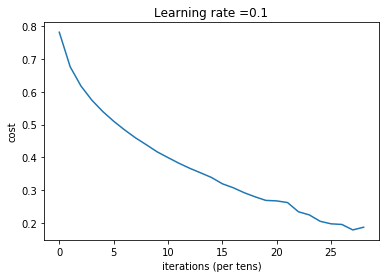

In [54]:
net.SGD(training_data)

In [59]:
#net.save(filename='net')

In [14]:
#net.load(filename='net')

In [58]:
pred = net.predict(X_test.T)
pred = np.argmax(pred, axis=0)
accuracy_score(y_test, pred)

0.8832828282828283

#### Relu as activation function in hidden layer

In [198]:
net1 = NeuralNetwork(layer_dims = [X_train.shape[1], 100,100, 10], itr = 300)

Cost after iteration 10: 0.775355
Cost after iteration 20: 0.653654
Cost after iteration 30: 0.588259
Cost after iteration 40: 0.540112
Cost after iteration 50: 0.500674
Cost after iteration 60: 0.471868


/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in log
/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide


Cost after iteration 70: 0.447580
Cost after iteration 80: 0.426964
Cost after iteration 90: 0.411245
Cost after iteration 100: 0.380879
Cost after iteration 110: 0.381549
Cost after iteration 120: 0.349045
Cost after iteration 130: 0.337850
Cost after iteration 140: 0.315883
Cost after iteration 150: 0.301691
Cost after iteration 160: 0.299342
Cost after iteration 170: 0.282770
Cost after iteration 180: 0.273680
Cost after iteration 190: 0.258164
Cost after iteration 200: 0.238707
Cost after iteration 210: 0.289563
Cost after iteration 220: 0.252015
Cost after iteration 230: 0.298048
Cost after iteration 240: 0.213997
Cost after iteration 250: 0.431062
Cost after iteration 260: 0.263358
Cost after iteration 270: 0.238791
Cost after iteration 280: 0.214722
Cost after iteration 290: 0.285241
Cost after iteration 300: 0.199673


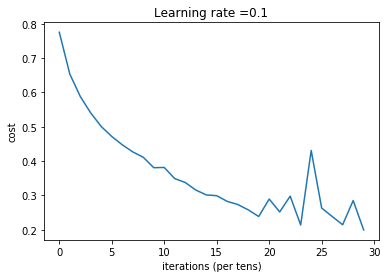

In [189]:
net1.SGD(training_data, print_cost=True)

In [166]:
#net1.save(filename='net12')

In [120]:
#net1.load(filename='net1')

In [192]:
pred = net1.predict(X_test.T)
pred = np.argmax(pred, axis=0)
accuracy_score(y_test, pred)

0.8834848484848485

#### Sigmoid function as activation function in hidden layers

In [201]:
net2 = NeuralNetwork(layer_dims = [X_train.shape[1], 100, 100, 10], itr = 300, activation='sigmoid')

Cost after iteration 10: 1.661318
Cost after iteration 20: 1.174798
Cost after iteration 30: 1.001998
Cost after iteration 40: 0.909742
Cost after iteration 50: 0.848181
Cost after iteration 60: 0.804097
Cost after iteration 70: 0.770759
Cost after iteration 80: 0.743875
Cost after iteration 90: 0.721087
Cost after iteration 100: 0.701151
Cost after iteration 110: 0.683382
Cost after iteration 120: 0.667349
Cost after iteration 130: 0.652742
Cost after iteration 140: 0.639318
Cost after iteration 150: 0.626880
Cost after iteration 160: 0.615271
Cost after iteration 170: 0.604364
Cost after iteration 180: 0.594056
Cost after iteration 190: 0.584263
Cost after iteration 200: 0.574916
Cost after iteration 210: 0.565960
Cost after iteration 220: 0.557356
Cost after iteration 230: 0.549073
Cost after iteration 240: 0.541085
Cost after iteration 250: 0.533364
Cost after iteration 260: 0.525881
Cost after iteration 270: 0.518612
Cost after iteration 280: 0.511533
Cost after iteration 290: 0.5

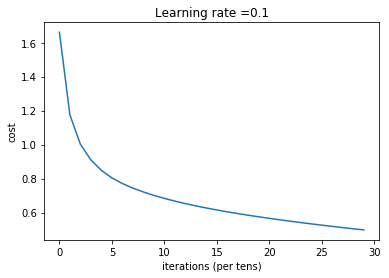

In [202]:
net2.SGD(training_data, print_cost=True)

In [ ]:
#net2.load(filename='net2')

In [203]:
pred = net2.predict(X_test.T)
pred = np.argmax(pred, axis=0)
accuracy_score(y_test, pred)

0.881010101010101

#### Multilayer perceptron using sklearn

In [135]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100), max_iter=300)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [143]:
pred = clf.predict(X_test)
#print(pred)
pred = np.argmax(pred, axis=1)
#print(pred)
accuracy_score(y_test, pred)

0.8686363636363637

#### Loss vs layers graph

In [86]:
c = []
for i in range(1,10):
    l = [X_train.shape[1]]
    l.extend([10]*i)
    l.extend([10])
    #print(l)
    net5 = NeuralNetwork(layer_dims = l, itr = 101)
    c.append(net5.SGD(training_data))
#     pred = net5.predict(X_test.T)
#     pred = np.argmax(pred, axis=0)
#     c.append(accuracy_score(y_test, pred))

/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:129: RuntimeWarning: divide by zero encountered in log
/home/neil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide


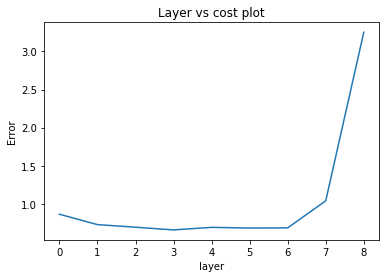

In [88]:
plt.plot(c)
plt.ylabel('Error')
plt.xlabel('layer')
plt.title('Layer vs cost plot')
plt.show()

#### Error vs number of epoch graph

In [94]:
d = []
for i in range(11,101,10):
    net5 = NeuralNetwork(layer_dims = [X_train.shape[1], 30, 30, 10], itr = i)
    net5.SGD(training_data)
    pred = net5.predict(X_test.T)
    pred = np.argmax(pred, axis=0)
    d.append(accuracy_score(y_test, pred))

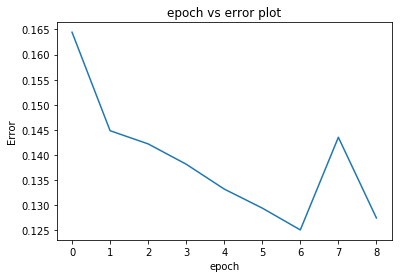

In [167]:
plt.plot(1-np.array(d))
plt.ylabel('Error')
plt.xlabel('epoch')
plt.title('epoch vs error plot')
plt.show()

#### Prediction of test dataset

In [168]:
test_df = pd.read_csv('Apparel/test.csv')
test_df = test_df/255.0

In [204]:
netr = NeuralNetwork(layer_dims = [X_train.shape[1], 100,100, 10], itr = 400)

In [205]:
netr.load(filename='net1')

In [206]:
pred = netr.predict(test_df.T)
pred = np.argmax(pred, axis=0)

In [208]:
p1 = clf.predict(test_df)
p1 = np.argmax(p1, axis=1)

In [212]:
accuracy_score(pred, p1)

0.9058300599545173

In [210]:
np.savetxt('res.csv', pred)

## Question 2
Consider the House Price Prediction dataset (Dataset Link). Suppose you
need to predict the Sale Price of a house and for the task you want to use a neural
network with 3 hidden layers. Write a report on how you would modify your above
neural network for such task with proper reasoning.

Yes, we can use neural network for linear regression, then output layer should be $g(z) = z$ , apart from that we need to use quadratic loss for output layer and we can use relu for hidden layers. The flaw of using neural network for linear regression is, neural network just becomes a complex $f(x) = WX +b$ and so the usage of neural network is none for linear regression and it just wastes resources.

So the changes that need to be made to use the neural network 
   - Make the ouput layer function as $g(z) = z$
   - Use  quadractic loss function instead of cross entropy loss
   - use one neuron in output layer as compared to 10 neurons